In [1]:
# Do not delete this cell. It ensures that you can do the imports,
# load datasets etc. in the same fashion as in any Python script
# in the project template.


import sys
sys.path.insert(0, '../..')
from bld.project_paths import project_paths_join as ppj
from bld.project_paths import project_paths as pp



In [77]:
import numpy as np
import json
import pickle
import pandas as pd
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'font.size': 20})


# Are fully algortihmic markets more collusive than fully human markets?

To answer this question we will compare the outcomes for the algorithmic market to the outcomes in the last super game of the human markets. We focus on the last super game as this allowed humans for some learning. Arguably this is the most accurate comparision.

First we load the needed data.

In [3]:
# Two firm algorithm markets
with open(ppj("OUT_DATA", "entire_price_grid_avg_prices_2_agents.pickle"), "rb") as f:
    entire_price_grid_avg_prices_2_agents = pickle.load(f)
with open(ppj("OUT_DATA", "super_star_avg_prices_2_agents.pickle"), "rb") as f:
    super_star_avg_prices_2_agents = pickle.load(f)

# Three firm algorithm markets
with open(ppj("OUT_DATA", "entire_price_grid_avg_prices_3_agents.pickle"), "rb") as f:
    entire_price_grid_avg_prices_3_agents = pickle.load(f)
with open(ppj("OUT_DATA", "super_star_avg_prices_3_agents.pickle"), "rb") as f:
    super_star_avg_prices_3_agents = pickle.load(f)


In [4]:
# we want to transform those to pandas dataframes as it will be easier to deal with them once we go over to plotting

In [5]:
with open(ppj("OUT_DATA", "data_group_level.pickle"), "rb") as f:
    data_group_level = pickle.load(f)

For the human data, we only need a subset for the last super game of the experiment. Furthermore, we need to take the mean across all round in this super game for each independent matching group to get the repsective independent observations.

In [6]:
data_last_super_game = data_group_level.loc[data_group_level['super_game'] == 3].groupby(['super_group_id_general', 'treatment'], as_index=False)[['winning_price', 'collusive']].mean()
data_humans = data_last_super_game.loc[data_last_super_game['treatment'].isin(['3H0A', '2H0A'])].copy()


In [105]:
# To make the plotting easier, we write the data into a structured dict
plotting_dict = {}


# First the fully human markets
plotting_dict['Humans'] = {}
plotting_dict['Humans']['means'] = list()
plotting_dict['Humans']['means'].extend(
                                    [data_humans.loc[data_humans['treatment'] == '2H0A']['winning_price'].mean(),
                                     data_humans.loc[data_humans['treatment'] == '3H0A']['winning_price'].mean()]
                                )
plotting_dict['Humans']['std'] = list()
plotting_dict['Humans']['std'].extend(
                                    [data_humans.loc[data_humans['treatment'] == '2H0A']['winning_price'].std(),
                                     data_humans.loc[data_humans['treatment'] == '3H0A']['winning_price'].std()]
                                )

# Now the algorithm markets
# First the super star

plotting_dict['Best algorithm'] = {}
plotting_dict['Best algorithm']['means'] = list()
plotting_dict['Best algorithm']['means'].extend(
                                                [super_star_avg_prices_2_agents.mean(),
                                                super_star_avg_prices_3_agents.mean()]
                                               )
plotting_dict['Best algorithm']['std'] = list()
plotting_dict['Best algorithm']['std'].extend(
                                                [super_star_avg_prices_2_agents.std(),
                                                 super_star_avg_prices_3_agents.std()]
                                               )

plotting_dict['Average algorithm'] = {}
plotting_dict['Average algorithm']['means'] = list()
plotting_dict['Average algorithm']['means'].extend(
                                                [entire_price_grid_avg_prices_2_agents.mean(),
                                                entire_price_grid_avg_prices_3_agents.mean()]
                                               )
plotting_dict['Average algorithm']['std'] = list()
plotting_dict['Average algorithm']['std'].extend(
                                                [entire_price_grid_avg_prices_2_agents.std(),
                                                 entire_price_grid_avg_prices_3_agents.std()]
                                               )

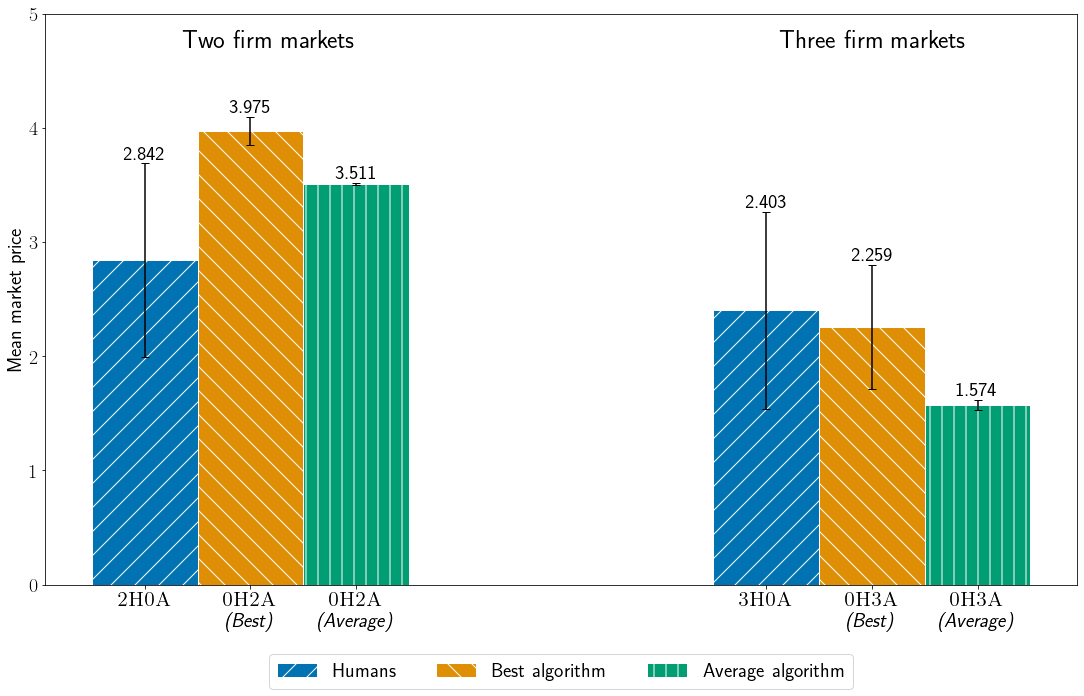

In [110]:
# set width of bar
barWidth = 0.17
distance = 0
all_colors = sns.color_palette('colorblind')

fig, ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)




all_groups = ['Humans', 'Best algorithm', 'Average algorithm']






all_r = [np.arange(2) + barWidth*x for x in range(3)] 

# Make the plot
for ix_group, group in enumerate(all_groups):
    ax.bar(all_r[ix_group], plotting_dict[group]['means'],
           yerr=plotting_dict[group]['std'],
           color=all_colors[ix_group], width=barWidth, edgecolor='white',
           label=group, capsize=4)

ax.set_ylim([0,5])
ax.set_ylabel('Mean market price')


# Create the label (mean price) over the error bar
rects = ax.patches
all_means = list(np.array([plotting_dict[group]['means']  for group in all_groups]).flat)
all_sem = list(np.array([plotting_dict[group]['std']  for group in all_groups]).flat)
labels = ['%.3f' % elem for elem in all_means]
distances = all_sem

label_ticks_pos = []
for rect, label, distance in zip(rects, labels, distances):
    height = rect.get_height() + distance
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom', fontweight='bold')
    
    # Posititon for x labels
    label_ticks_pos.append(rect.get_x() + rect.get_width() / 2)
    

    
labels_bars = ['\\textsc{2H0A}', '\\textsc{3H0A}', '\\textsc{0H2A} \n \\textit{(Best)}', '\\textsc{0H3A} \n \\textit{(Best)}', 
               '\\textsc{0H2A} \n  \\textit{(Average)}', '\\textsc{0H3A} \n \\textit{(Average)}']

ax.set_xticks(label_ticks_pos)
ax.set_xticklabels(labels_bars)


# Adding top labels with matplotlib magic numbers
ax.text(0.06, 4.7, 'Two firm markets', fontsize=25)
ax.text(1.02, 4.7, 'Three firm markets', fontsize=25)

hatches = ['/',  '/', '\\', '\\', '|', '|' ]

# Loop over the bars to add hatches
for i,thisbar in enumerate(rects):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

# Create legend & Show graphic
ax.legend(loc='lower center', bbox_to_anchor =(0.5,-0.2), ncol=3)
fig.savefig(ppj("OUT_FIGURES", "bar_plot_algortihm_v_humans.pdf"), bbox_inches='tight')

## Next up we use mann whitney u tests to compare the respective samples.

In [9]:
from scipy.stats import mannwhitneyu

### We start by comparing the market prices within a respective market size.

Two firm market:

In [10]:
mannwhitneyu(
    data_humans.loc[data_humans['treatment'] == '2H0A']['winning_price'],
    super_star_avg_prices_2_agents,
    use_continuity=False,
    alternative='two-sided'
)[-1]

2.4544708263240423e-19

In [11]:
mannwhitneyu(
    data_humans.loc[data_humans['treatment'] == '2H0A']['winning_price'],
    entire_price_grid_avg_prices_2_agents,
    use_continuity=False,
    alternative='two-sided'
)[-1]

0.0010815422804083224


The algortihmic markets are more collusive than the human markets at $p<0.01$. This is the case for the super star algorithm and the average of the grid search.

Three firm market:


In [12]:
mannwhitneyu(
    data_humans.loc[data_humans['treatment'] == '3H0A']['winning_price'],
    super_star_avg_prices_3_agents,
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.9803403942308063

In [13]:
mannwhitneyu(
    data_humans.loc[data_humans['treatment'] == '3H0A']['winning_price'],
    entire_price_grid_avg_prices_3_agents,
    use_continuity=False,
    alternative='two-sided'
)[-1]

0.0011131274804479718

There exist no statistically significant differences between the prices in the three firm markets with the super star algorithms and humans. Interestingly, the average algorithm from the grid search is *less* collusive than the human market with this difference being statistically significant at $p<0.01$.

### Next, we compare the outcomes between market sizes.

In [14]:
mannwhitneyu(
    super_star_avg_prices_3_agents,
    super_star_avg_prices_2_agents,
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.0

In [15]:
mannwhitneyu(
    entire_price_grid_avg_prices_2_agents,
    entire_price_grid_avg_prices_3_agents,
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.0

Two firm algortihmic markets lead to hire markets prices compared to the case where three algorithms populate the same market ($p<0.01$).

In [16]:
a = data_humans.loc[data_humans['treatment'] == '3H0A']['winning_price'].values

In [17]:
mannwhitneyu(
    data_humans.loc[data_humans['treatment'] == '3H0A']['collusive'],
    data_humans.loc[data_humans['treatment'] == '2H0A']['collusive'],
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.46394035370574516

While market prices are higher in two firm human markets as suggested by the literature on human collusion, those difference are not statistically significant. This can also be confirmed by the means of regression anaylsis which you find in the appendix.

Note however that this is only the case in the last super game:



In [18]:
data_humans_first_super_game = data_group_level.loc[(data_group_level['super_game'] == 1) & 
                                                    (data_group_level['treatment'].isin(['3H0A', '2H0A']))].groupby(['super_group_id_general', 'treatment'], as_index=False)[['winning_price', 'collusive']].mean()
data_humans_second_super_game = data_group_level.loc[(data_group_level['super_game'] == 2) & 
                                                    (data_group_level['treatment'].isin(['3H0A', '2H0A']))].groupby(['super_group_id_general', 'treatment'], as_index=False)[['winning_price', 'collusive']].mean()


In [19]:
data_humans_all_super_game = data_group_level.loc[
                                                    (data_group_level['treatment'].isin(['3H0A', '2H0A']))].groupby(['super_group_id_general', 'treatment'], as_index=False)[['winning_price', 'collusive']].mean()


In [20]:
mannwhitneyu(
    data_humans_first_super_game.loc[data_humans_first_super_game['treatment'] == '3H0A']['winning_price'],
    data_humans_first_super_game.loc[data_humans_first_super_game['treatment'] == '2H0A']['winning_price'],
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.04530386472278079

In [21]:
mannwhitneyu(
    data_humans_second_super_game.loc[data_humans_second_super_game['treatment'] == '3H0A']['winning_price'],
    data_humans_second_super_game.loc[data_humans_second_super_game['treatment'] == '2H0A']['winning_price'],
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.050961936967763306

In [22]:
mannwhitneyu(
    data_humans_all_super_game.loc[data_humans_all_super_game['treatment'] == '3H0A']['winning_price'],
    data_humans_all_super_game.loc[data_humans_all_super_game['treatment'] == '2H0A']['winning_price'],
    use_continuity=False,
    alternative='two-sided'

)[-1]

0.04042397933690852

In [23]:
data_humans_all_super_game

,super_group_id_general,treatment,winning_price,collusive
0,session_02062021_1000_1,3H0A,1.327044,0.037736
1,session_02062021_1000_2,3H0A,2.207547,0.364780
2,session_02062021_1130_1,3H0A,1.238994,0.075472
3,session_07062021_1130_1,3H0A,1.874214,0.251572
4,session_07062021_1130_2,3H0A,1.666667,0.327044
5,session_08062021_1630_3H0A_1,3H0A,3.283019,0.729560
6,session_17062021_1600_1,3H0A,1.452830,0.157233
7,session_20052021_1000_1,2H0A,2.622642,0.572327
8,session_20052021_1000_2,2H0A,2.767296,0.534591
9,session_21052021_1000_1,2H0A,3.421384,0.748428


This shows the importance of learning for humans, which appears to be more pronounce in larger and therefore strategically more complex markets.